In [121]:
import pandas as pd
import numpy as np
import requests
import json
import time

from prophet import Prophet

from keys import token_inegi, token_banxico

In [122]:
####################################################################
#### This file is used to check which is the last recorded quarter 
#### from previous forecasts. If a new record is observed, then the
#### file is updated and everything gets re-forecasted.
####################################################################

#Import INEGI Last Values file
lv= pd.read_csv('INEGI_LastValues.csv')

#Last records
last_year_record= int(lv[(lv['Var'] == 'PIB') & (lv['timestamp'] == lv['timestamp'].max())]['Y'])
last_quarter_record= int(lv[(lv['Var'] == 'PIB') & (lv['timestamp'] == lv['timestamp'].max())]['Q'])

In [123]:
####################################################################
#### Query INEGI's API to get latest macroeconomic data for GDP, 
#### industrial GDP and Investment. If new data is identified,
#### leave a new record in INEGI_LastValues.csv
####################################################################

#Query
query= f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6207061899/es/0700/false/BISE/2.0/{token_inegi}?type=json'
response= requests.get(query)

#Transform JSON to dataframe
dat= pd.json_normalize(response.json()['Series'][0]['OBSERVATIONS']).rename(columns= {'OBS_VALUE': 'pib'})

dat['y']= pd.to_numeric([dat['TIME_PERIOD'][i].split('/')[0] for i in range(0, len(dat))])
dat['q']= pd.to_numeric([dat['TIME_PERIOD'][i].split('/')[1] for i in range(0, len(dat))])
dat['pib']= pd.to_numeric(dat['pib'])
dat['yq']= [str(dat['y'][i])+'Q'+str(dat['q'][i]) for i in range(0, len(dat))]

#Check that last observation is the one registered 
#If new observations are published, then update INEGI_lastValues.py file

y_check= dat.iloc[-1, -3] == last_year_record #Year check
q_check= dat.iloc[-1, -2] == last_quarter_record #Quarter check

#Validation and updates
if (y_check == True) & (q_check == True):
    print('----')
    print('Last YQ has not changed. Forecasting with last registered values')
    
    pib_lastValue = [dat.iloc[-1, -3], dat.iloc[-1, -2]]

elif (y_check == True) & (q_check == False):
    print('----')
    print('Year is same, but new Q data published. Forecasting with new quarter data')
    print('Updating INEGI_LastValues.csv file')
    
    lv= lv.append({'Var': 'PIB', 
                   'Y': dat.iloc[-1, -3], 
                   'Q': dat.iloc[-1, -2], 
                   'timestamp': time.time()}, ignore_index= True)
    lv.to_csv('INEGI_LastValues.csv', index= False)
        
    pib_lastValue = [dat.iloc[-1, -3], dat.iloc[-1, -2]]
        
elif (y_check == False):
    print('----')
    print('New year, new data published. Forecasting with new quarter data')
    print('Updating INEGI_LastValues.csv file')
    
    lv= lv.append({'Var': 'PIB', 
                   'Y': dat.iloc[-1, -3], 
                   'Q': dat.iloc[-1, -2], 
                   'timestamp': time.time()}, ignore_index= True)
    lv.to_csv('INEGI_LastValues.csv', index= False)
        
    pib_lastValue = [dat.iloc[-1, -3], dat.iloc[-1, -2]]
        
##Filter selected columns
dat= dat[['yq', 'pib']]

----
Last YQ has not changed. Forecasting with last registered values


In [124]:
####################################################################
#### Facebook Prophet model to forecast automatically GDP growth
#### based on new historic recors , towards 2032
####################################################################

#Prepare data
ts= dat[['yq', 'pib']].rename(columns= {'yq': 'ds',  'pib': 'y'})
ts['ds'] = pd.PeriodIndex(ts['ds'], freq='Q').to_timestamp()

#Fit Model
m= Prophet(seasonality_mode='multiplicative')
m.fit(ts)

#Forecast period
#Remaining quarters of the year to be forecasted
if pib_lastValue[1] == 1:
    remaining_qs = [str(pib_lastValue[0])+i for i in ['Q2', 'Q3', 'Q4']]
elif pib_lastValue[1] == 2:
    remaining_qs = [str(pib_lastValue[0])+i for i in ['Q3', 'Q4']]
elif pib_lastValue[1] == 3:
    remaining_qs = [str(pib_lastValue[0])+i for i in ['Q4']]
else:
    remaining_qs = []

#Next years to be forecasted
future_ds= np.append(remaining_qs, 
                     [str(y)+q for y in range(pib_lastValue[0] + 1, 2033) for q in ['Q1', 'Q2', 'Q3', 'Q4']])

#Forecast to 2023
future= pd.DataFrame(columns=['ds'])
future['ds']= pd.PeriodIndex(future_ds, freq='Q').to_timestamp()
forecast = m.predict(future)

#Integrate historic w/ forecast dataframes
fnl= pd.DataFrame(columns= ['ds', 'y', 'yhat'])
fnl['ds'] = pd.PeriodIndex(ts['ds'], freq='Q')
fnl['y'] = ts['y']

forecast['y'] = np.nan
forecast['ds'] = pd.PeriodIndex(forecast['ds'], freq='Q')
f= forecast[['ds', 'y', 'yhat']]

fnl= pd.concat([fnl, f]).reset_index(drop= True)
fnl['year'] = pd.PeriodIndex(fnl['ds'], freq='Q').year
fnl['quarter'] = pd.PeriodIndex(fnl['ds'], freq='Q').quarter

index_cut= fnl[(fnl['year'] == pib_lastValue[0]) & (fnl['quarter'] == pib_lastValue[1])].index[0]
fnl['full'] = np.append(fnl.iloc[:index_cut+1, 1], 
                        fnl.iloc[index_cut+1:, 2])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [128]:
####################################################################
#### Banxico API query to retrieve latest records of macroeconomic  
#### expectations survey.
####################################################################

#Proyección año en curso
url= 'https://www.banxico.org.mx/SieAPIRest/service/v1/series/SR14448/datos/oportuno'
response= requests.get(url, headers= {'Bmx-Token': token_banxico})
proy_año_en_curso= pd.to_numeric(response.json()['bmx']['series'][0]['datos'][0]['dato']) / 100
año= int(response.json()['bmx']['series'][0]['datos'][0]['fecha'][-4:])

#Proyección próximo año
url= 'https://www.banxico.org.mx/SieAPIRest/service/v1/series/SR14455/datos/oportuno'
response= requests.get(url, headers= {'Bmx-Token': token_banxico})
proy_año_proximo= pd.to_numeric(response.json()['bmx']['series'][0]['datos'][0]['dato'])/ 100

#Proyección en 2 años
url= 'https://www.banxico.org.mx/SieAPIRest/service/v1/series/SR14462/datos/oportuno'
response= requests.get(url, headers= {'Bmx-Token': token_banxico})
proy_en_2_años= pd.to_numeric(response.json()['bmx']['series'][0]['datos'][0]['dato'])/ 100

#Proyección década
url= 'https://www.banxico.org.mx/SieAPIRest/service/v1/series/SR14469/datos/oportuno'
response= requests.get(url, headers= {'Bmx-Token': token_banxico})
proy_decada= pd.to_numeric(response.json()['bmx']['series'][0]['datos'][0]['dato'])/ 100

In [129]:
####################################################################
#### Ajustar valores de proyecciones PIB a expectativas del sector
#### de Banxico
####################################################################

################
### AJUSTAR 2022
X = (proy_año_en_curso + 1) * fnl.loc[fnl['year'] == año-1, 'full'].sum() / fnl.loc[fnl['year'] == año, 'full'].sum()
fnl.loc[fnl['year'] == año, 'full'] = fnl.loc[fnl['year'] == año, 'full'] * X

################
### AJUSTAR 2023
X = (proy_año_proximo + 1) * fnl.loc[fnl['year'] == año, 'full'].sum() / fnl.loc[fnl['year'] == año+1, 'full'].sum()
fnl.loc[fnl['year'] == año+1, 'full'] = fnl.loc[fnl['year'] == año+1, 'full'] * X

################
### AJUSTAR 2024
X = (proy_en_2_años + 1) * fnl.loc[fnl['year'] == año+1, 'full'].sum() / fnl.loc[fnl['year'] == año+2, 'full'].sum()
fnl.loc[fnl['year'] == año+2, 'full'] = fnl.loc[fnl['year'] == año+2, 'full'] * X

######################
### AJUSTAR 2025-2032

yoy= fnl.groupby('year', as_index=True)[['full']].sum()
yoy['pct_var'] = np.append([np.nan], [(yoy.iloc[i,0] /yoy.iloc[i-1,0] -1) * 100 for i in range(1, len(yoy))])

X= (((proy_decada * 100) * 11) - (yoy.loc[(yoy.index <= año+2) & (yoy.index >= año) , 'pct_var'].sum()) - (yoy.loc[yoy.index > año+2, 'pct_var'].sum())) / 8
yoy.loc[yoy.index > año+2, 'pct_var'] = yoy.loc[yoy.index > año+2, 'pct_var'] + X

for year in range(año+3,2033):
    X = (yoy.loc[yoy.index== year, 'pct_var'] / 100 +1) * fnl.loc[fnl['year'] == year-1, 'full'].sum() / fnl.loc[fnl['year'] == year, 'full'].sum()
    X= X[X.index[0]]
    fnl.loc[fnl['year'] == year, 'full'] = fnl.loc[fnl['year'] == year, 'full'] * X

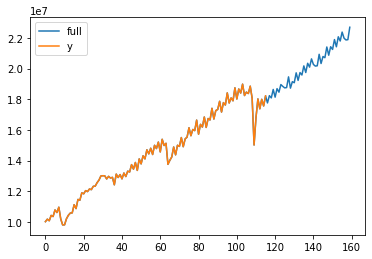

,full,pct_var
year,,
2018,7.408018e+07,2.194995
2019,7.394246e+07,-0.185907
2020,6.790331e+07,-8.167358
2021,7.116076e+07,4.797192
2022,7.272630e+07,2.200000
2023,7.425355e+07,2.100000
2024,7.581288e+07,2.100000
2025,7.668300e+07,1.147725
2026,7.873882e+07,2.680934


In [134]:
yoy= fnl.groupby('year', as_index=True)[['full']].sum()
yoy['pct_var'] = np.append([np.nan], [(yoy.iloc[i,0] /yoy.iloc[i-1,0] -1) * 100 for i in range(1, len(yoy))])

fnl[['full', 'y']].plot()
plt.show()
yoy.tail(15)

In [136]:
fnl[['year', 'quarter', 'full']]

,year,quarter,full
0,1993,1,1.000889e+07
1,1993,2,1.017104e+07
2,1993,3,1.006626e+07
3,1993,4,1.041610e+07
4,1994,1,1.034339e+07
...,...,...,...
155,2031,4,2.238697e+07
156,2032,1,2.199135e+07
157,2032,2,2.187226e+07
158,2032,3,2.189166e+07
